In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# Load data

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


# Basic autoencoder

In [3]:
# basic autoencoder encodes image to latent space, then decode it back
latent_dim = 64

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim

        # encoder compress image to 64 dimension latent vector
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu')
        ])

        # decoder reconstructs orginal image from latent vector
        self.decoder = tf.keras.Sequential([
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [4]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [5]:
# train with image as both input and target
autoencoder.fit(x_train, x_train, epochs=10, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0396 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0122 - val_loss: 0.0105
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0087 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.008

In [6]:
# test encoding and decoding test set
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

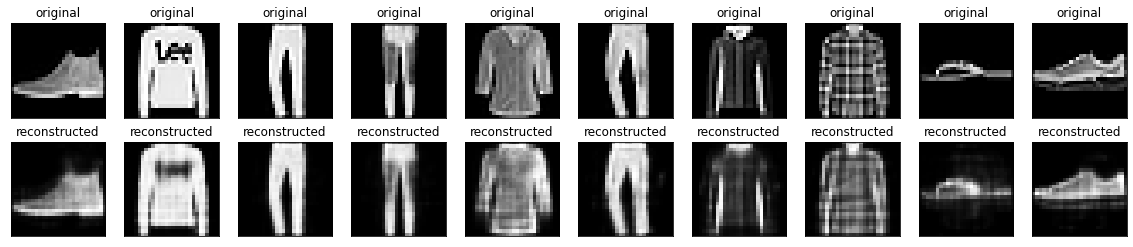

In [7]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Image denoising

In [8]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [10]:
# add random noise to images
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

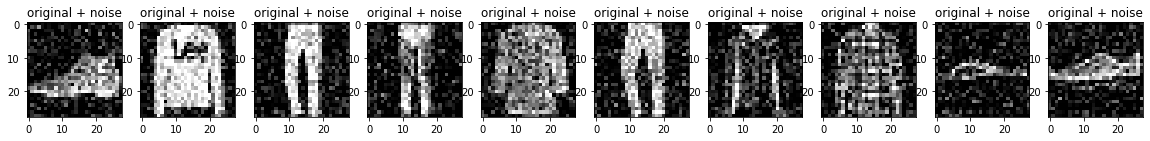

In [11]:
# plot noisy images
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [12]:
# convolutional autoencoder to remove noise from image
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

In [13]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [14]:
# train with noisy image as input, original image as target
autoencoder.fit(x_train_noisy, x_train, epochs=10, shuffle=True, validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 12s 5ms/step - loss: 0.0326 - val_loss: 0.0096
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0091 - val_loss: 0.0085
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0072 - val_loss: 0.0073
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.00

In [15]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [16]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [17]:
# plot model on test set
encoded_imgs = autoencoder.encoder(x_test[:10]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

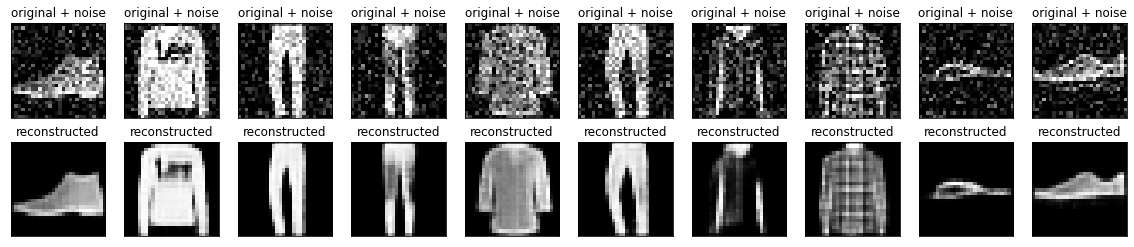

In [18]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

# Anomaly detection

### load ECG data

In [19]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [20]:
# last column is label
labels = raw_data[:, -1]

# the other columns are ECG data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

In [21]:
# normalize data to [0, 1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [22]:
# split the normal and abnormal data
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

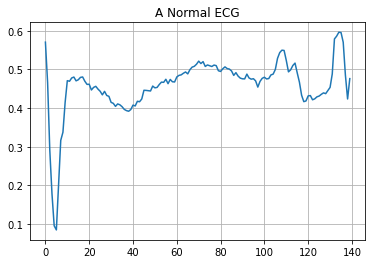

In [23]:
# plot normal ECG
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

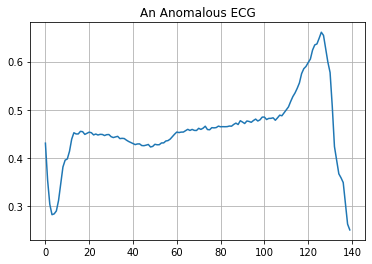

In [24]:
# plot abnormal ECG
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### build model

In [25]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation='relu'),
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu')
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(140, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [26]:
autoencoder.compile(optimizer='adam', loss='mae')

In [27]:
history = autoencoder.fit(normal_train_data, normal_train_data, epochs=20, batch_size=512, validation_data=(test_data, test_data), shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 47ms/step - loss: 0.0574 - val_loss: 0.0525
Epoch 2/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0543 - val_loss: 0.0507
Epoch 3/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0509 - val_loss: 0.0487
Epoch 4/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0473 - val_loss: 0.0469
Epoch 5/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0436 - val_loss: 0.0450
Epoch 6/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0399 - val_loss: 0.0430
Epoch 7/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0366 - val_loss: 0.0412
Epoch 8/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0336 - val_loss: 0.0397
Epoch 9/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0311 - val_loss: 0.0385
Epoch 10/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0290 - val_loss: 0.0374
Epoch 11/20
5/5 [============

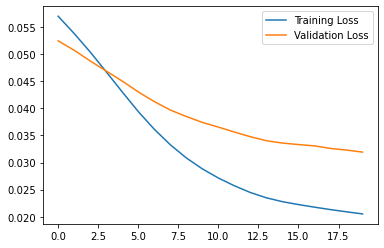

In [28]:
# plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

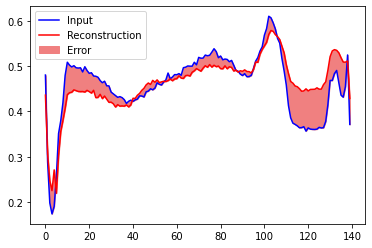

In [29]:
# plot reconstruction error on test set for normal ECG
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.show()

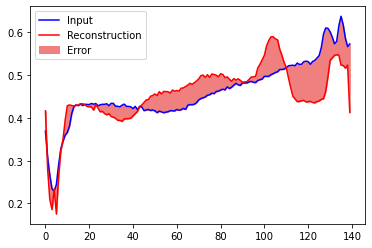

In [30]:
# plot reconstruction error on test set for anomalous ECG, which the error should be greater
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.show()

### detect anomalies

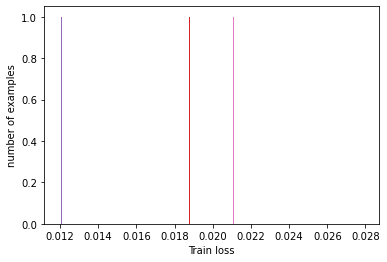

In [31]:
# detect anomalies by calculating whether reconstruction error is greater than a threshold
# use mean error on the normal examples as the threshold

# calculate mae of normal train data reconstruction
reconstructions = autoencoder.predict(normal_train_data[:10])
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data[:10])

plt.hist(train_loss, bins=50)
plt.xlabel('Train loss')
plt.ylabel('number of examples')
plt.show()

In [32]:
# choose threshold as 1 std from the mean error
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold:", threshold)

Threshold: 0.02212756


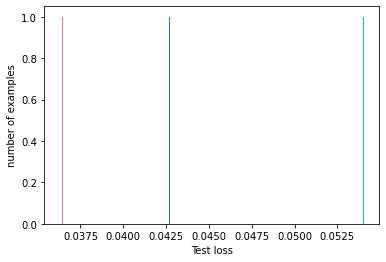

In [33]:
# reconstruction error for anomalous samples are higher
reconstructions = autoencoder.predict(anomalous_test_data[:10])
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data[:10])

plt.hist(test_loss, bins=50)
plt.xlabel('Test loss')
plt.ylabel('number of examples')
plt.show()

In [34]:
# classift ECG as anomaly if reconstruction error > threshold
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [35]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.826
Precision = 0.9923469387755102
Recall = 0.6946428571428571
